In [1]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np

from tqdm import tqdm

from zeste_vision.data_tools.loader import get_test_video_frames
from zeste_vision.analysis.occlusion import test

occlusion_analysis::test: loading frames
occlusion_analysis::test: frames loaded


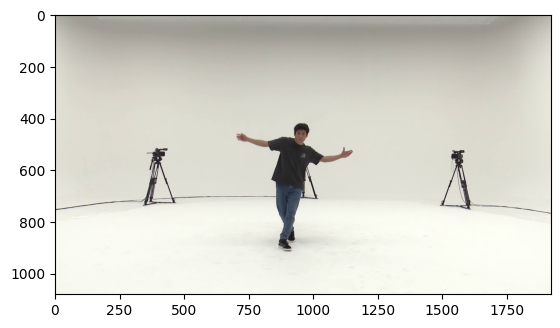

I0000 00:00:1730172986.691377   25451 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1730172986.776108   25507 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 470.256.02), renderer: NVIDIA GeForce GTX 1080/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1730172986.861138   25506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730172986.899660   25500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730172986.924747   25505 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/home/lamsey/anaconda3/envs/zeste_vision/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: Use

occlusion_analysis::test: pose estimation complete


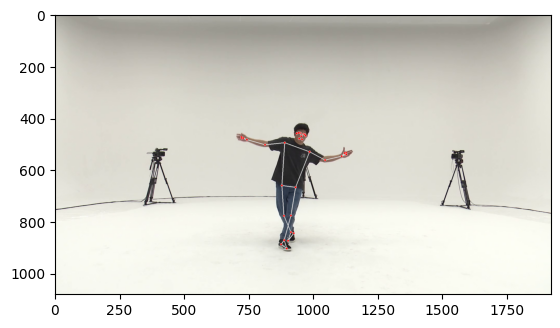

In [2]:
test(use_cv=False)

In [3]:
from zeste_vision.data_tools.loader import get_test_video_frame, load_keypoint3d
DRAWING = mp.solutions.drawing_utils
POSE_CONNECTIONS = mp.solutions.pose.POSE_CONNECTIONS

I0000 00:00:1730172987.820146   25451 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1730172987.892134   25533 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 470.256.02), renderer: NVIDIA GeForce GTX 1080/PCIe/SSE2
W0000 00:00:1730172987.978404   25526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730172988.012990   25530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


occlusion_analysis::test: pose estimation complete


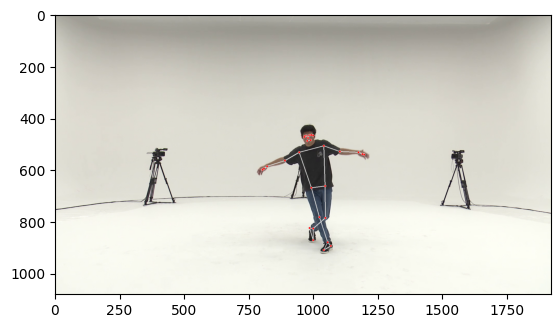

In [4]:
video_path = "/home/lamsey/hrl/zeste_vision/data/aist_dance/"
video_file = video_path + "gBR_sBM_c01_d04_mBR0_ch01.mp4"
test_frame = get_test_video_frame(video_file, frame_i=100)

# instantiate pose estimator
MEDIAPIPE_OPTIONS = {
    "static_image_mode": False,
    "model_complexity": 1,
    "smooth_landmarks": True,
    "enable_segmentation": True,
    "smooth_segmentation": True,
    "min_detection_confidence": 0.5,
    "min_tracking_confidence": 0.5
}

pose = mp.solutions.pose.Pose(**MEDIAPIPE_OPTIONS)

# run pose estimator on test frame
results = pose.process(test_frame)
print("occlusion_analysis::test: pose estimation complete")

render_image = test_frame.copy()
DRAWING.draw_landmarks(render_image, results.pose_landmarks, POSE_CONNECTIONS)

rgb_frame = cv2.cvtColor(render_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_frame)
plt.show()

(783, 428, 430, 495)


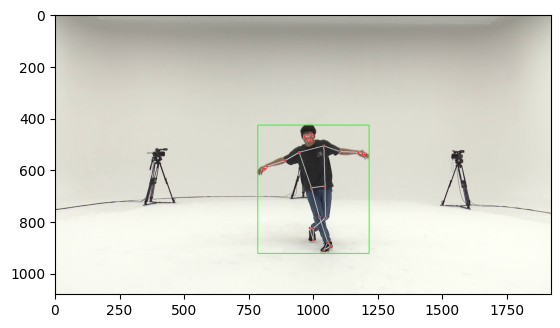

In [5]:
# results
# a = results.pose_landmarks.landmark
# print(a)
mask = results.segmentation_mask.astype(np.uint8)
plt.imshow(mask)

# get bounding box
bbox = cv2.boundingRect(mask)
print(bbox)

# draw bounding box
cv2.rectangle(render_image, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 2)

rgb_frame = cv2.cvtColor(render_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_frame)

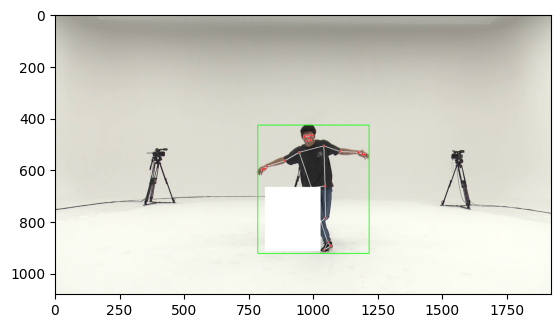

In [6]:
from zeste_vision.analysis.pose_tools import compute_bounding_box, add_occlusion
from time import sleep

bbox = compute_bounding_box(results)

for _ in range(1):
    new_img = add_occlusion(render_image, bbox, percent=0.5)
    rgb_frame = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)
    plt.show()


comparing results


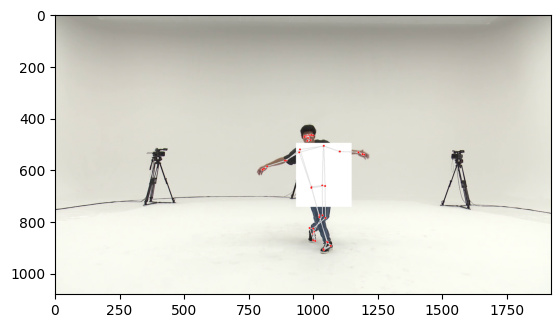

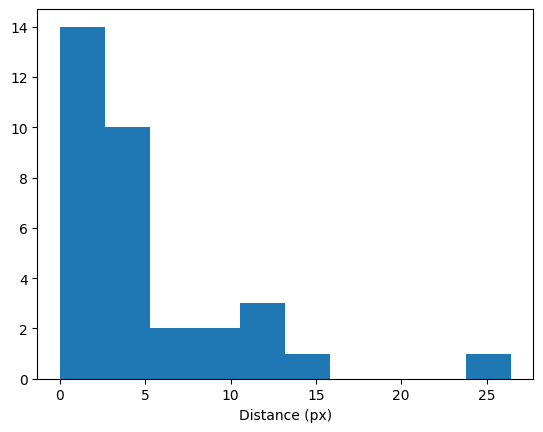

In [7]:
bbox = compute_bounding_box(results)

occluded_frame = test_frame.copy()
occluded_frame = add_occlusion(occluded_frame, bbox, percent=0.5)

new_results = pose.process(occluded_frame)

render_image = occluded_frame.copy()
DRAWING.draw_landmarks(render_image, new_results.pose_landmarks, POSE_CONNECTIONS)

# rgb_frame = cv2.cvtColor(render_image, cv2.COLOR_BGR2RGB)
# plt.imshow(rgb_frame)

# cv2.imshow("occluded", render_image)

# compare results
print("comparing results")
img_w = test_frame.shape[1]
img_h = test_frame.shape[0]
distances = []
for i in range(len(results.pose_landmarks.landmark)):
    x1, y1 = results.pose_landmarks.landmark[i].x, results.pose_landmarks.landmark[i].y
    x1_px = int(x1 * img_w)
    y1_px = int(y1 * img_h)
    x2, y2 = new_results.pose_landmarks.landmark[i].x, new_results.pose_landmarks.landmark[i].y
    x2_px = int(x2 * img_w)
    y2_px = int(y2 * img_h)
    # print(f"landmark {i}: ({x1}, {y1}) vs ({x2}, {y2})")
    # distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    distance = np.sqrt((x1_px - x2_px) ** 2 + (y1_px - y2_px) ** 2)
    distances.append(distance)

DRAWING.draw_landmarks(render_image, results.pose_landmarks, POSE_CONNECTIONS)

rgb_frame = cv2.cvtColor(render_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_frame)
plt.show()

# histogram
plt.hist(distances)
plt.xlabel("Distance (px)")
plt.show()

In [12]:
annot_path = "/home/lamsey/hrl/zeste_vision/data/aist_dance_annotations/"
annot_file = annot_path + "gBR_sBM_cAll_d04_mBR0_ch01.pkl"

annotations = load_keypoint3d(annot_file)

n = annotations.shape[0]
# f = plt.figure()
# for i in range(n):
#     for point in annotations[i]:
#         x, y, z = point
#         plt.scatter(x, y, c="r")
#     plt.show()
#     sleep(0.1)
#     f.clear()

<Figure size 640x480 with 0 Axes>